<a href="https://colab.research.google.com/github/tesdem/Examples/blob/master/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# rather than importing the whole sklearn library, we will import certain modules 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_boston
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn import metrics


In [ ]:
# we load the dataset and save it as the variable boston
boston = load_boston()

# if we want to know what sort of detail is provided with this dataset, we can call .keys()
boston.keys()

# the info at the .DESCR key will tell us more 
print(boston.DESCR)

In [5]:

# we can use pandas to create a dataframe, which is basically a way of storing and operating on tabular data 
# here we pass in both the data and the column names as variables
boston_X = pd.DataFrame(boston.data, columns = boston.feature_names)

# we can then look at the top of the dataframe to see the sort of values it contains
boston_X.head()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [6]:
# pandas has a lot of functionality to assist with exploratory data analysis
# .describe() provide summary statistics on all numeric columns
print(boston_X.describe())

             CRIM          ZN       INDUS  ...     PTRATIO           B       LSTAT
count  506.000000  506.000000  506.000000  ...  506.000000  506.000000  506.000000
mean     3.613524   11.363636   11.136779  ...   18.455534  356.674032   12.653063
std      8.601545   23.322453    6.860353  ...    2.164946   91.294864    7.141062
min      0.006320    0.000000    0.460000  ...   12.600000    0.320000    1.730000
25%      0.082045    0.000000    5.190000  ...   17.400000  375.377500    6.950000
50%      0.256510    0.000000    9.690000  ...   19.050000  391.440000   11.360000
75%      3.677083   12.500000   18.100000  ...   20.200000  396.225000   16.955000
max     88.976200  100.000000   27.740000  ...   22.000000  396.900000   37.970000

[8 rows x 13 columns]


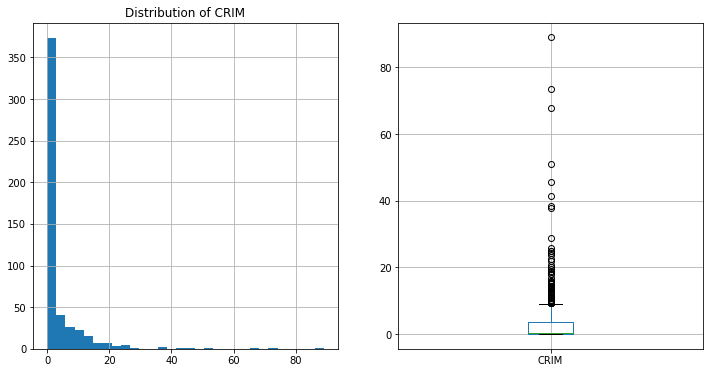

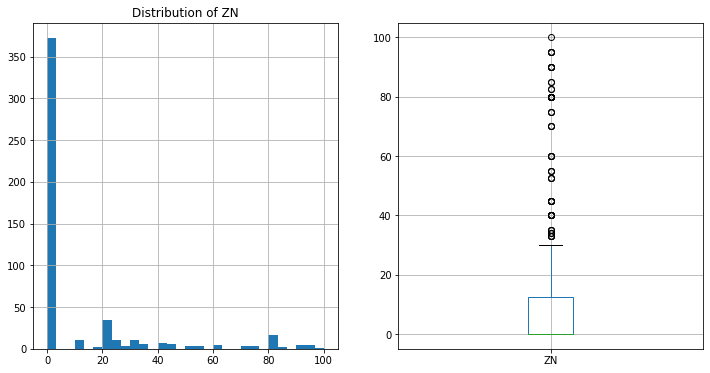

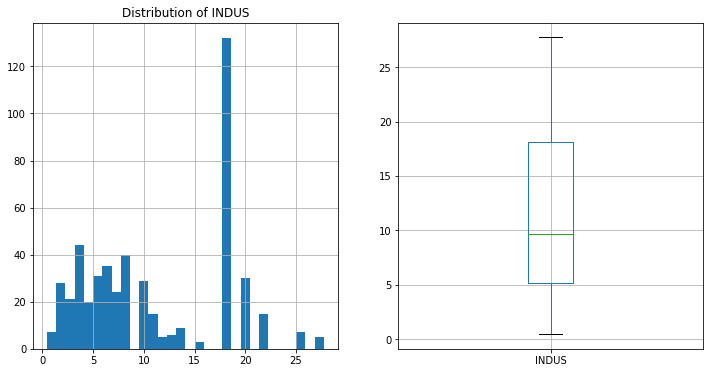

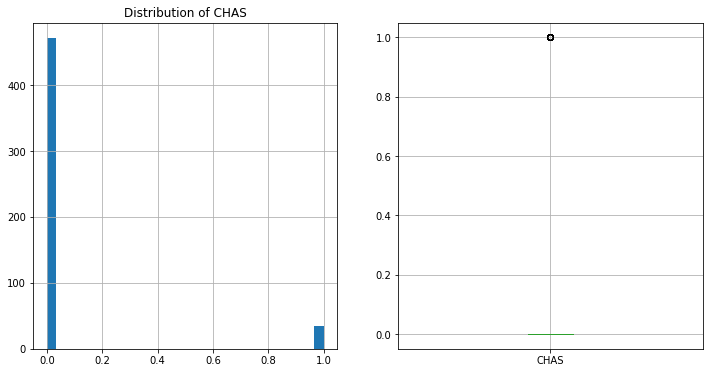

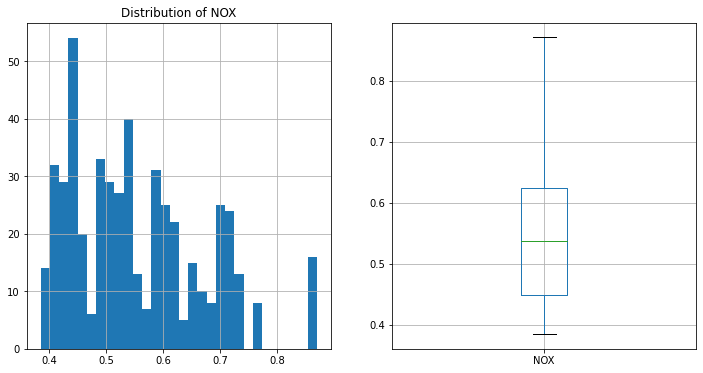

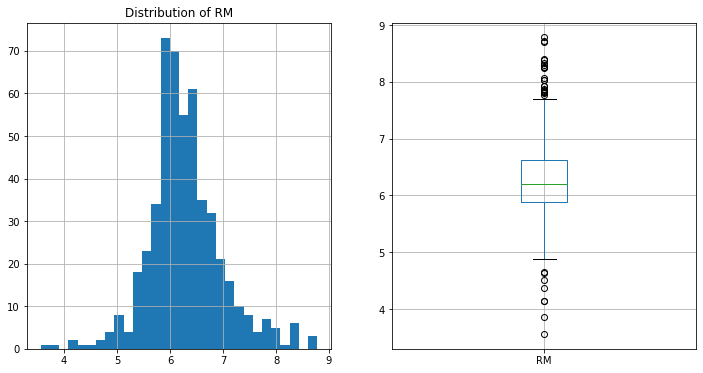

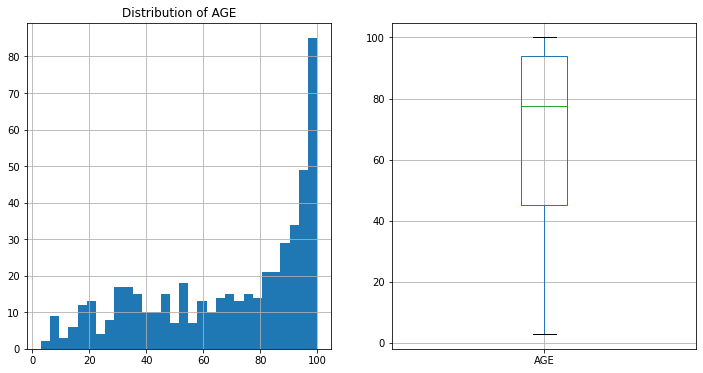

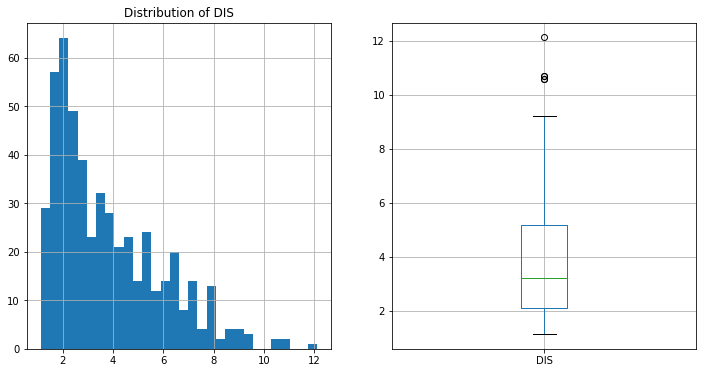

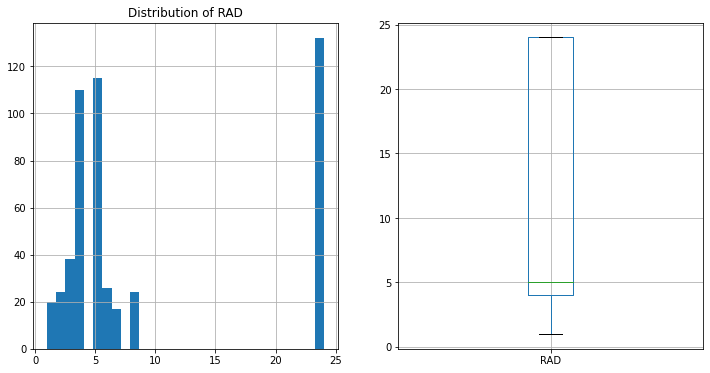

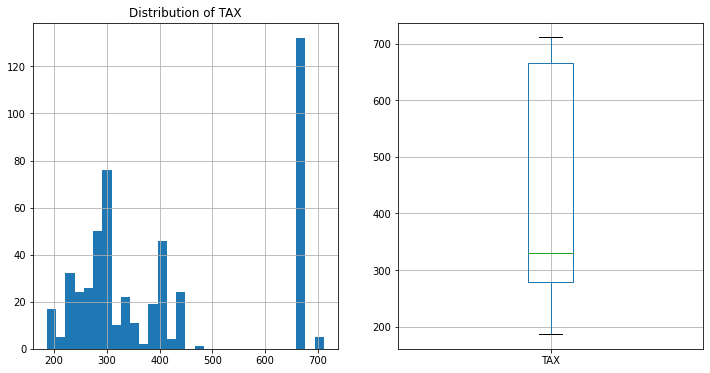

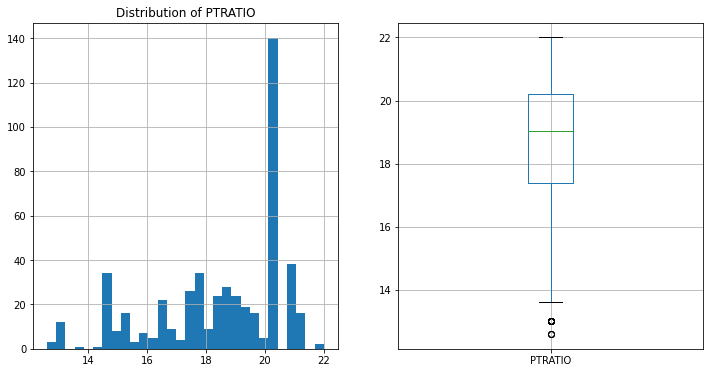

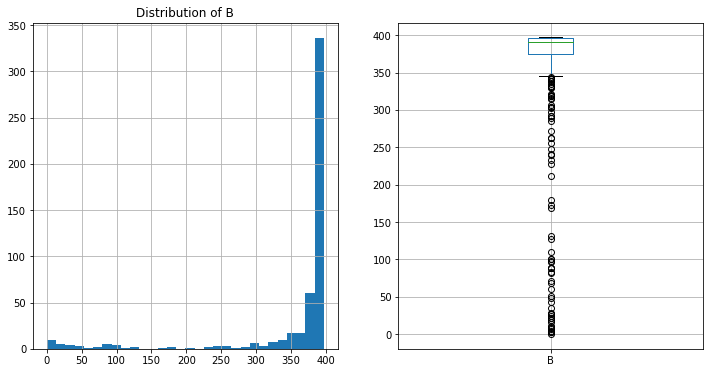

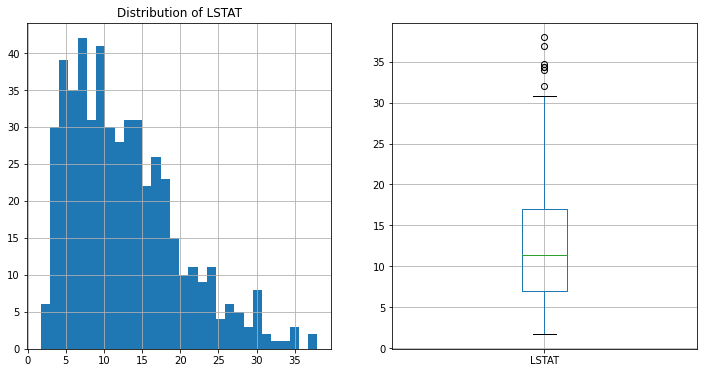

In [8]:
"""* For each feature, we can see the `count`, or number of data entries, the `mean` value, and the `standard deviation`, `min`, `max` and `quartile` values. 
* We can see that the range of values for each feature differs quite a lot, so we can start to think about whether to apply normalization to the data. 
* We can also see that the `CHAS` faeture is either a `(1,0)` value. If we look back at our description, we can see that this is an example of a `categorical` variable. These are values used to describe non-numeric data. In this case,  a `1` indicates the house borders near the river, and a `0` that it doesn't.
"""

# we can build on this analysis by plotting the distribution and boxplots for each column

# we loop through all the columns
for col in boston_X.columns:
    # and for each column we create space for one row with 2 charts 
    f, axes = plt.subplots(1, 2, figsize=(12, 6))
    # our first chart is a histogram and we set the title 
    boston_X[col].hist(bins = 30, ax = axes[0])
    axes[0].set_title('Distribution of '+ col)
    # our second column is the boxplot 
    boston_X.boxplot(column = col, ax = axes[1])
    # we then use this to command to display the charts
    plt.show()

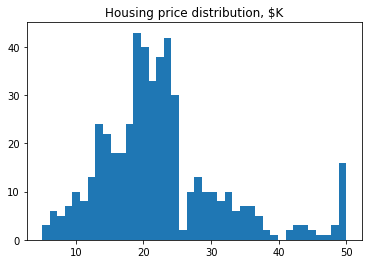

In [9]:

"""* A `histogram` tells is the number of times, or frequency, a value occurs within a `bin`, or bucket, that splits the data (and which we defined). A histogram shows the frequency with which values occur within each of these bins, and can tell us about the distribution of data. 
* A `boxplot` captures within the box the `interquartile range`, the range of values from Q1/25th percentile to Q3/75th percentile, and the median value. It also captures the `min` and `max` values of each feature.
* Together, these charts show us the distribution of values for each feature. We can start to make judgements about how to treat the data, for example whether we want to deal with outliers; or whether we want to normalize the data.
"""

# we can now look at our target variable 
boston_y = boston.target
# we can plot a histogram in a slightly different way 
plt.hist(boston_y, bins = 40)
plt.title('Housing price distribution, $K')
plt.show()

In [7]:
# we can also see the shape of the data
print(boston_X.shape)

(506, 13)


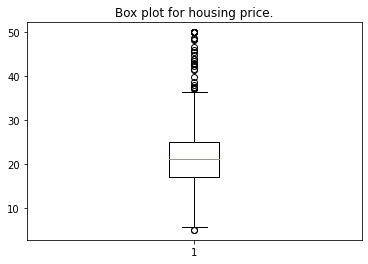

In [10]:

# and the same for the boxplot
plt.boxplot(boston_y)
plt.title('Box plot for housing price.')
plt.show()


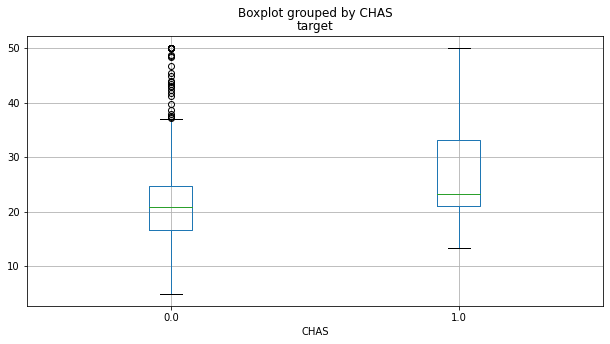

In [11]:
# another thing we can do is plot a boxplot of one variable against the target variable 
# it is interesting to see how house value distribution differs by CHAS, the categorical variable 

# here we create a grouped dataframe that includes the target variable
grouped_df = boston_X.copy()   # note we create a copy of the data here so that any changes don't impact the original data
grouped_df['target'] = boston_y.copy()

# we then plot it here
f, axes = plt.subplots(1, 1, figsize=(10, 5))   
grouped_df.boxplot(column='target', by = 'CHAS', ax = axes)
plt.show()


#The `interquartile range`for houses next to the river is higher than for those houses not next to the river, and the `min` and `max` values differ too.

#This suggests this could be an important variable for us to include in our model, given that as it differs, the target value distribution changes.


In [13]:
# lets start by removing outliers

# here we define the columns where we have identified there could be outliers
numeric_columns = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

# this function can be used on any dataset to return a list of index values for the outliers 
def get_outliers(data, columns):
    # we create an empty list
    outlier_idxs = []
    for col in columns:
        elements = data[col]
        # we get the mean value for each column
        mean = elements.mean()
        # and the standard deviation of the column
        sd = elements.std()
        # we then get the index values of all values higher or lower than the mean +/- 2 standard deviations
        outliers_mask = data[(data[col] > mean + 3*sd) | (data[col]  < mean  - 3*sd)].index
        # and add those values to our list
        outlier_idxs  += [x for x in outliers_mask]
    return list(set(outlier_idxs))

# we call the function we just created on the boston dataset
boston_outliers = get_outliers(boston_X, numeric_columns)

# and drop those values from our feature and target values
boston_X = boston_X.drop(boston_outliers, axis = 0)
boston_y = pd.DataFrame(boston_y).drop(boston_outliers, axis = 0).values.ravel()

In [14]:

# we can check that this code has worked by looking at the shape of our data 
print (boston_X.shape)
print (boston_y.shape)

# we can also create a function to normalize our data
# first lets look at the data before normalisation
boston_X[0:10]


(400, 13)
(400,)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10


In [15]:
# this function loops through columns in a data set and defines a predefined scaler to each
def scale_numeric(data, numeric_columns, scaler):
    for col in numeric_columns:
        data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1))
    return data

# we can now define the scaler we want to use and apply it to our dataset 

# a good exercise would be to research waht StandardScaler does - it is from the scikit learn library 
scaler = StandardScaler()
boston_X = scale_numeric(boston_X, numeric_columns, scaler)

# here we can see the result 
boston_X[0:10]


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,-0.545139,0.851904,-1.310284,0.0,-0.101390,0.577463,-0.130445,0.188259,-0.932134,-0.567188,-1.541835,0.550362,-1.173284
1,-0.538806,-0.495572,-0.591673,0.0,-0.744024,0.302213,0.376318,0.675789,-0.804750,-0.910640,-0.326739,0.550362,-0.487059
2,-0.538812,-0.495572,-0.591673,0.0,-0.744024,1.667742,-0.282104,0.675789,-0.804750,-0.910640,-0.326739,0.408220,-1.329994
3,-0.537280,-0.495572,-1.329910,0.0,-0.846473,1.333509,-0.848051,1.284494,-0.677365,-1.037844,0.110695,0.471084,-1.509798
4,-0.526213,-0.495572,-1.329910,0.0,-0.846473,1.599823,-0.537335,1.284494,-0.677365,-1.037844,0.110695,0.550362,-1.115548
5,-0.538040,-0.495572,-1.329910,0.0,-0.846473,0.318299,-0.370880,1.284494,-0.677365,-1.037844,0.110695,0.453272,-1.135343
6,-0.520408,0.440176,-0.470898,0.0,-0.231779,-0.428810,-0.078659,1.005627,-0.422597,-0.471785,-1.590439,0.504960,0.055653
7,-0.503434,0.440176,-0.470898,0.0,-0.231779,-0.142835,1.012545,1.222406,-0.422597,-0.471785,-1.590439,0.550362,1.164170
8,-0.483312,0.440176,-0.470898,0.0,-0.231779,-1.109788,1.156806,1.295555,-0.422597,-0.471785,-1.590439,0.191690,2.942416
9,-0.495743,0.440176,-0.470898,0.0,-0.231779,-0.443109,0.635247,1.579036,-0.422597,-0.471785,-1.590439,0.194484,0.826006


In [16]:

"""###  : Split the data
* In order to train our model and see how well it performs, we need to split our data into training and testing sets.
* We can then train our model on the training set, and test how well it has generalised to the data on the test set.
* There are a number of options for how we can split the data, and for what proportion of our original data we set aside for the test set.
"""

# a common way for splitting our dataset is using train_test_split 

# as an exercise, go to the scikit learn documentation to learn more about this function and the parameters available 
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(boston_X, boston_y, test_size = 0.2, random_state = 5)

# get shape of test and training sets
print('Training Set:')
print('Number of datapoints: ', X_train.shape[0])
print('Number of features: ', X_train.shape[1])
print('\n')
print('Test Set:')
print('Number of datapoints: ', X_test.shape[0])
print('Number of features: ', X_test.shape[1])

Training Set:
Number of datapoints:  320
Number of features:  13


Test Set:
Number of datapoints:  80
Number of features:  13


Mean squared error:  40.22082653608083
Mean absolute error:  4.054879377335569
R^2 :  0.38606716342991065


4.054879377335569

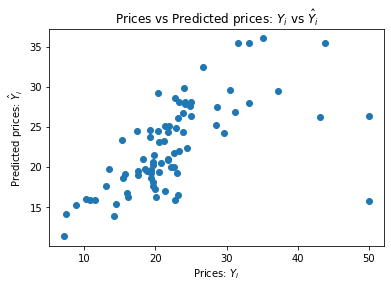

In [21]:
def evaluate(Y_test, Y_pred):
    # this block of code returns all the metrics we are interested in 
    mse = metrics.mean_squared_error(Y_test, Y_pred)
    msa = metrics.mean_absolute_error(Y_test, Y_pred)
    r2 = metrics.r2_score(Y_test, Y_pred)

    print("Mean squared error: ", mse)
    print("Mean absolute error: ", msa)
    print("R^2 : ", r2)
    
    # this creates a chart plotting predicted and actual 
    plt.scatter(Y_test, Y_pred)
    plt.xlabel("Prices: $Y_i$")
    plt.ylabel("Predicted prices: $\hat{Y}_i$")
    plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")

evaluate(Y_test, Y_pred)

# we can explore how metrics are dervied in a little more detail by looking at MAE
# here we will implement MAE using numpy, building it up step by step

# with MAE, we get the absolute values of the error - as you can see this is of the difference between the actual and predicted values
np.abs(Y_test - Y_pred)

# we will then sum them up 
np.sum(np.abs(Y_test - Y_pred))

# then divide by the total number of predictions/actual values
# as you will see, we get to the same score implemented above 
np.sum(np.abs(Y_test - Y_pred))/len(Y_test)

In [22]:
"""### : Refine our dataset
* This step allows us to add or modify features of the datatset. We might do this if, for example, some combination of features better represents the problems space and so is an indicator of the target variable. 
* Here, we create one additional feature as an example, but you should reflect on our EDA earlier and see whether there are other features that can be added to our dataset.
"""

# here we are using pandas functionality to add a new column called LSTAT_2, which will feature values that are the square of LSTAT values
boston_X['LSTAT_2'] = boston_X['LSTAT'].map(lambda x: x**2)

# we can run our train_test_split function and see that we have an additional features
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(boston_X, boston_y, test_size = 0.2, random_state = 5)

print('Number of features after dataset refinement: ', X_train.shape[1])


Number of features after dataset refinement:  14


Mean squared error:  40.22082653608083
Mean absolute error:  4.054879377335569
R^2 :  0.38606716342991065


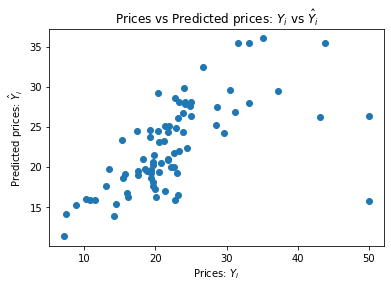

In [23]:
# we can now run the same code as before on our refined dataset to see if things have improved 
lm.fit(X_train, Y_train)

Y_pred = lm.predict(X_test)

evaluate(Y_test, Y_pred)

Mean squared error:  40.24520057499999
Mean absolute error:  4.104649999999999
R^2 :  0.3856951168028011


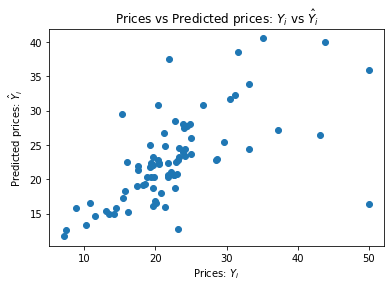

In [24]:
"""### Test Alternative Models
* Once we got a nice baseline model working for this dataset, we also can try something more sophisticated and rather different, e.g. RandomForest Regressor. So, let's do so and also evaluate the result.
"""

# as you can see, its very similar code to instantiate the model
# we are able to pass in additional parameters as the model is created, so optionally you can view the documentation and play with these values

rfr = RandomForestRegressor()
rfr.fit(X_train, Y_train)
Y_pred = rfr.predict(X_test)

evaluate(Y_test, Y_pred)

Mean squared error:  42.0871504329375
Mean absolute error:  4.115998749999998
R^2 :  0.3575794961531604


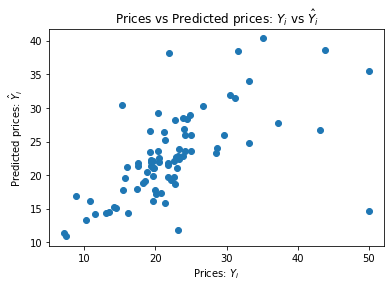

In [26]:
"""### : Choose the best model and optimise its parameters
* We can see that we have improved our model as we have added features and trained new models.
* At the point that we feel comfortable with a good model, we can start to tune the parameters of the model.
* There are a number of ways to do this, and a common way is shown below
"""

## grid search is a 'brute force' search, one that will explore every possible combination of parameters that you provide it

# we first define the parameters we want to search as a dictionary. Explore the documentation to what other options are avaiable
params = {'n_estimators': [100, 200], 'max_depth' : [2, 10, 20]}

# we then create a grid search object with our chosen model and paramters. We also use cross validation here - explored more in Day 2
grid = model_selection.GridSearchCV(rfr, params, cv=5)

# we fit our model to the data as before
grid.fit(X_train, Y_train)

# one output of the grid search function is that we can get the best_estimator - the model and parameters that scored best on the training data - 
#  and save it as a new a model
best_model = grid.best_estimator_

# and use it to predict and evaluate as before
Y_pred = best_model.predict(X_test)

evaluate(Y_test, Y_pred)
